In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime
import math
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# For LSTM model
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.optimizers import Adam

# For Prophet model
from prophet import Prophet

In [6]:
# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

In [7]:
def load_and_prepare_data(csv_path):
    """Load and prepare the dry whey dataset."""
    # Load data
    df = pd.read_csv(csv_path)
    
    # Clean and prepare data
    df['Week Ending Date'] = pd.to_datetime(df['Week Ending Date'], format='%m/%d/%Y')
    df['Report Date'] = pd.to_datetime(df['Report Date'], format='%m/%d/%Y')
    
    # Process Date column to create full dates with year
    dates = []
    for i, row in df.iterrows():
        month_day = row['Date'].split('/')
        month = int(month_day[0])
        day = int(month_day[1])
        
        ref_date = row['Week Ending Date']
        ref_year = ref_date.year
        
        if month > ref_date.month + 1 and ref_date.month < 3:
            year = ref_year - 1
        else:
            year = ref_year
            
        dates.append(datetime(year, month, day))
    
    df['FullDate'] = dates
    
    # Clean the Sales column
    df['Sales'] = df['Sales'].str.replace(',', '').astype(float)
    
    # Remove duplicate date entries
    unique_dates_df = df.drop_duplicates(subset=['FullDate']).sort_values('FullDate')
    
    return unique_dates_df

In [8]:
csv_path = 'Datamart-Export_DY_WK100-Dry Whey Prices and Sales_20170829_122601.csv'
data = load_and_prepare_data(csv_path)
    
print("Data loaded successfully. Shape:", data.shape)

Data loaded successfully. Shape: (286, 6)


In [9]:
def create_lstm_dataset(dataset, time_step=1):
    """Create time series dataset for LSTM model."""
    X, y = [], []
    for i in range(len(dataset) - time_step - 1):
        a = dataset[i:(i + time_step), 0]
        X.append(a)
        y.append(dataset[i + time_step, 0])
    return np.array(X), np.array(y)

def evaluate_model(y_true, y_pred, model_name):
    """Calculate and print error metrics."""
    rmse = math.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    r2 = r2_score(y_true, y_pred)
    
    print(f"\n{model_name} Performance Metrics:")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE: {mae:.4f}")
    print(f"MAPE: {mape:.2f}%")
    print(f"R²: {r2:.4f}")
    
    return {"rmse": rmse, "mae": mae, "mape": mape, "r2": r2}

def build_lstm_model(time_step):
    """Build LSTM model architecture."""
    model = Sequential()
    model.add(LSTM(units=50, return_sequences=True, input_shape=(time_step, 1)))
    model.add(Dropout(0.2))
    model.add(LSTM(units=50, return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(units=1))
    
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')
    return model

def plot_predictions(dates, actual, train_pred, test_pred, split_idx, model_name):
    """Plot actual vs predicted values."""
    plt.figure(figsize=(16, 8))
    
    # Plot actual data
    plt.plot(dates, actual, 'b-', label='Actual Data', alpha=0.6)
    
    # Find non-NaN indices for train and test predictions
    train_indices = ~np.isnan(train_pred.flatten())
    test_indices = ~np.isnan(test_pred.flatten())
    
    # Only plot non-NaN values with their corresponding dates
    if np.any(train_indices):
        train_dates = dates[train_indices]
        train_values = train_pred.flatten()[train_indices]
        plt.plot(train_dates, train_values, 'r-', label='Training Predictions', linewidth=2, alpha=0.7)
    
    if np.any(test_indices):
        test_dates = dates[test_indices]
        test_values = test_pred.flatten()[test_indices]
        plt.plot(test_dates, test_values, 'g-', label='Test Predictions', linewidth=2)
    
    # Add vertical line to separate train/test
    if split_idx < len(dates):
        plt.axvline(x=dates[split_idx], color='k', linestyle='--', alpha=0.5)
        plt.text(dates[split_idx], plt.ylim()[1]*0.9, 'Train | Test', 
                horizontalalignment='center', backgroundcolor='w')
    
    plt.title(f'{model_name} Prediction of Dry Whey Prices')
    plt.xlabel('Date')
    plt.ylabel('Weighted Price ($)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.gcf().autofmt_xdate()
    plt.tight_layout()
    plt.show()

In [10]:
def lstm_prediction(data, time_step=10, epochs=100, batch_size=32):
    """Implement LSTM model for time series prediction."""
    # Prepare data
    df = data[['FullDate', 'Weighted Prices']].copy()
    dataset = df[['Weighted Prices']].values
    
    # Normalize the data
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(dataset)
    
    # Create sequences
    X, y = create_lstm_dataset(scaled_data, time_step)
    X = X.reshape(X.shape[0], X.shape[1], 1)
    
    # Split data
    train_size = int(len(X) * 0.8)
    X_train, X_test = X[0:train_size], X[train_size:len(X)]
    y_train, y_test = y[0:train_size], y[train_size:len(y)]
    
    # Build and train model
    model = build_lstm_model(time_step)
    history = model.fit(X_train, y_train, validation_data=(X_test, y_test),
                       epochs=epochs, batch_size=batch_size, verbose=1)
    
    # Make predictions
    train_predict = model.predict(X_train)
    test_predict = model.predict(X_test)
    
    # Invert predictions back to original scale
    train_predict = scaler.inverse_transform(train_predict)
    test_predict = scaler.inverse_transform(test_predict)
    y_train_inv = scaler.inverse_transform(y_train.reshape(-1, 1))
    y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))
    
    # Evaluate model
    train_metrics = evaluate_model(y_train_inv, train_predict, "LSTM (Training)")
    test_metrics = evaluate_model(y_test_inv, test_predict, "LSTM (Testing)")
    
    # Prepare data for plotting
    all_dates = df['FullDate'].iloc[time_step+1:].values
    actual_prices = scaler.inverse_transform(scaled_data[time_step+1:])
    
    # Calculate correct indices for train and test predictions
    train_end_idx = train_size
    
    # Create arrays for plotting
    train_pred_plot = np.full((len(actual_prices), 1), np.nan)
    test_pred_plot = np.full((len(actual_prices), 1), np.nan)
    
    # The train predictions start at time_step+1 and end at train_size+time_step
    # Accounting for the offset in actual_prices
    train_indices = np.arange(len(train_predict))
    if len(train_indices) <= len(train_pred_plot):
        train_pred_plot[train_indices] = train_predict
    
    # The test predictions continue from where train predictions end
    test_start = train_size
    test_indices = np.arange(test_start, test_start + len(test_predict))
    if len(test_indices) <= len(test_pred_plot) and max(test_indices) < len(test_pred_plot):
        for i, idx in enumerate(test_indices):
            if idx < len(test_pred_plot):
                test_pred_plot[idx] = test_predict[i]
    
    # Plot results
    plot_predictions(all_dates, actual_prices, train_pred_plot, test_pred_plot, train_size, "LSTM")
    
    # Plot learning curve
    plt.figure(figsize=(12, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('LSTM Learning Curve')
    plt.xlabel('Epochs')
    plt.ylabel('Loss (MSE)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()
    
    return {
        'train_metrics': train_metrics,
        'test_metrics': test_metrics,
        'model': model,
        'scaler': scaler
    }

Epoch 1/100


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.4846 - val_loss: 0.0577
Epoch 2/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0986 - val_loss: 0.0240
Epoch 3/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0493 - val_loss: 0.0082
Epoch 4/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0187 - val_loss: 0.0080
Epoch 5/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0283 - val_loss: 0.0049
Epoch 6/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0161 - val_loss: 0.0054
Epoch 7/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0153 - val_loss: 0.0044
Epoch 8/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0145 - val_loss: 0.0048
Epoch 9/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0112 - val_loss: 0.0049
Epoch 10/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0109 - val_loss: 0.0058
Epoch 11/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0101 - val_loss: 0.0069
Epoch 12/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0102 - val_loss: 0.0081
Epoch 13/1

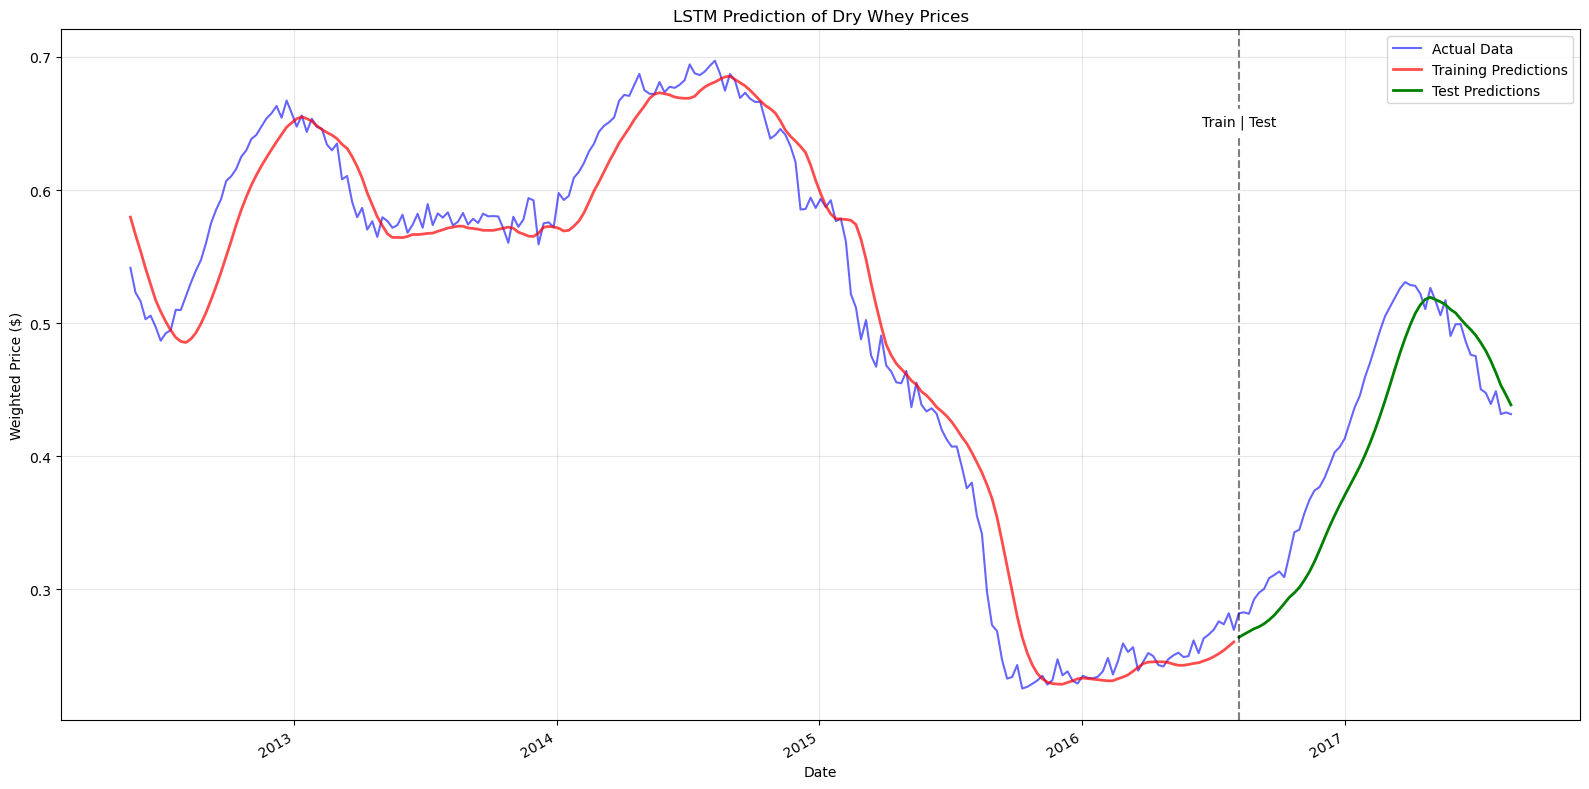

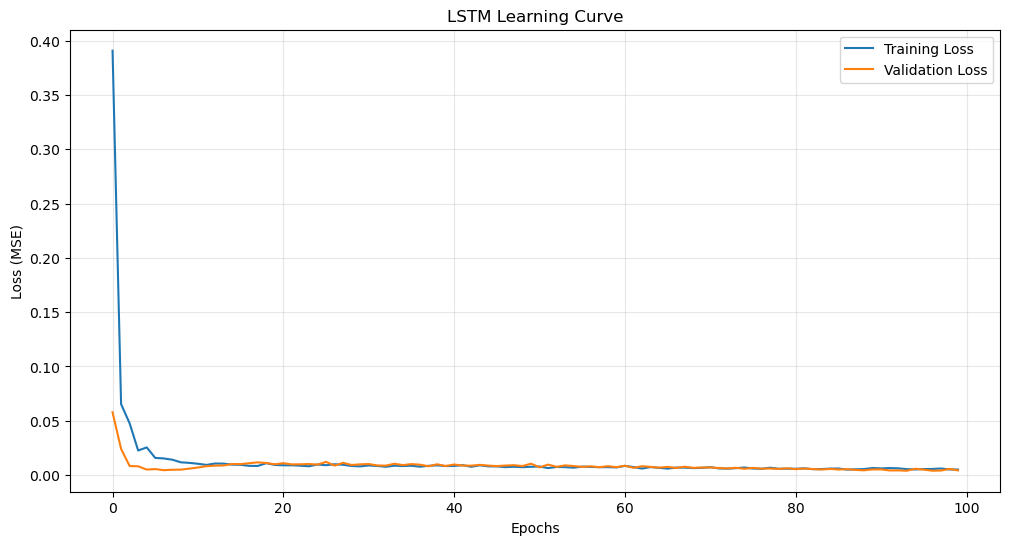

In [11]:
lstm_results = lstm_prediction(data, time_step=10, epochs=100, batch_size=32)

In [12]:
def prophet_prediction(data):
    """Implement Prophet model for time series prediction."""
    # Prepare data in Prophet format
    prophet_df = data[['FullDate', 'Weighted Prices']].rename(
        columns={'FullDate': 'ds', 'Weighted Prices': 'y'})
    
    # Split data
    train_size = int(len(prophet_df) * 0.8)
    train_df = prophet_df[:train_size]
    test_df = prophet_df[train_size:]
    
    # Create and train model
    model = Prophet(yearly_seasonality=True, 
                    weekly_seasonality=False,
                    daily_seasonality=False,
                    changepoint_prior_scale=0.05)
    model.fit(train_df)
    
    # Make predictions for both train and test periods
    future_train = model.make_future_dataframe(periods=0, freq='D')
    future_train = future_train[future_train['ds'] <= train_df['ds'].max()]
    forecast_train = model.predict(future_train)
    
    future_test = pd.DataFrame({'ds': test_df['ds']})
    forecast_test = model.predict(future_test)
    
    # Evaluate model
    train_metrics = evaluate_model(train_df['y'].values, 
                                 forecast_train['yhat'].values, 
                                 "Prophet (Training)")
    
    test_metrics = evaluate_model(test_df['y'].values, 
                                forecast_test['yhat'].values, 
                                "Prophet (Testing)")
    
    # Plot results
    plt.figure(figsize=(16, 8))
    plt.plot(prophet_df['ds'], prophet_df['y'], 'b-', label='Actual Data', alpha=0.6)
    plt.plot(forecast_train['ds'], forecast_train['yhat'], 'r-', 
             label='Training Predictions', linewidth=2, alpha=0.7)
    plt.plot(forecast_test['ds'], forecast_test['yhat'], 'g-', 
             label='Test Predictions', linewidth=2)
    
    # Add vertical line to separate train/test
    split_date = train_df['ds'].max()
    plt.axvline(x=split_date, color='k', linestyle='--', alpha=0.5)
    plt.text(split_date, plt.ylim()[1]*0.9, 'Train | Test', 
             horizontalalignment='center', backgroundcolor='w')
    
    plt.title('Prophet Prediction of Dry Whey Prices')
    plt.xlabel('Date')
    plt.ylabel('Weighted Price ($)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.gcf().autofmt_xdate()
    plt.tight_layout()
    plt.show()
    
    # Show Prophet components
    fig = model.plot_components(forecast_train)
    plt.tight_layout()
    plt.show()
    
    return {
        'train_metrics': train_metrics,
        'test_metrics': test_metrics,
        'model': model,
    }


21:02:57 - cmdstanpy - INFO - Chain [1] start processing
21:02:57 - cmdstanpy - INFO - Chain [1] done processing



Prophet (Training) Performance Metrics:
RMSE: 0.0433
MAE: 0.0370
MAPE: 8.68%
R²: 0.9200

Prophet (Testing) Performance Metrics:
RMSE: 0.4033
MAE: 0.3785
MAPE: 87.23%
R²: -21.3519


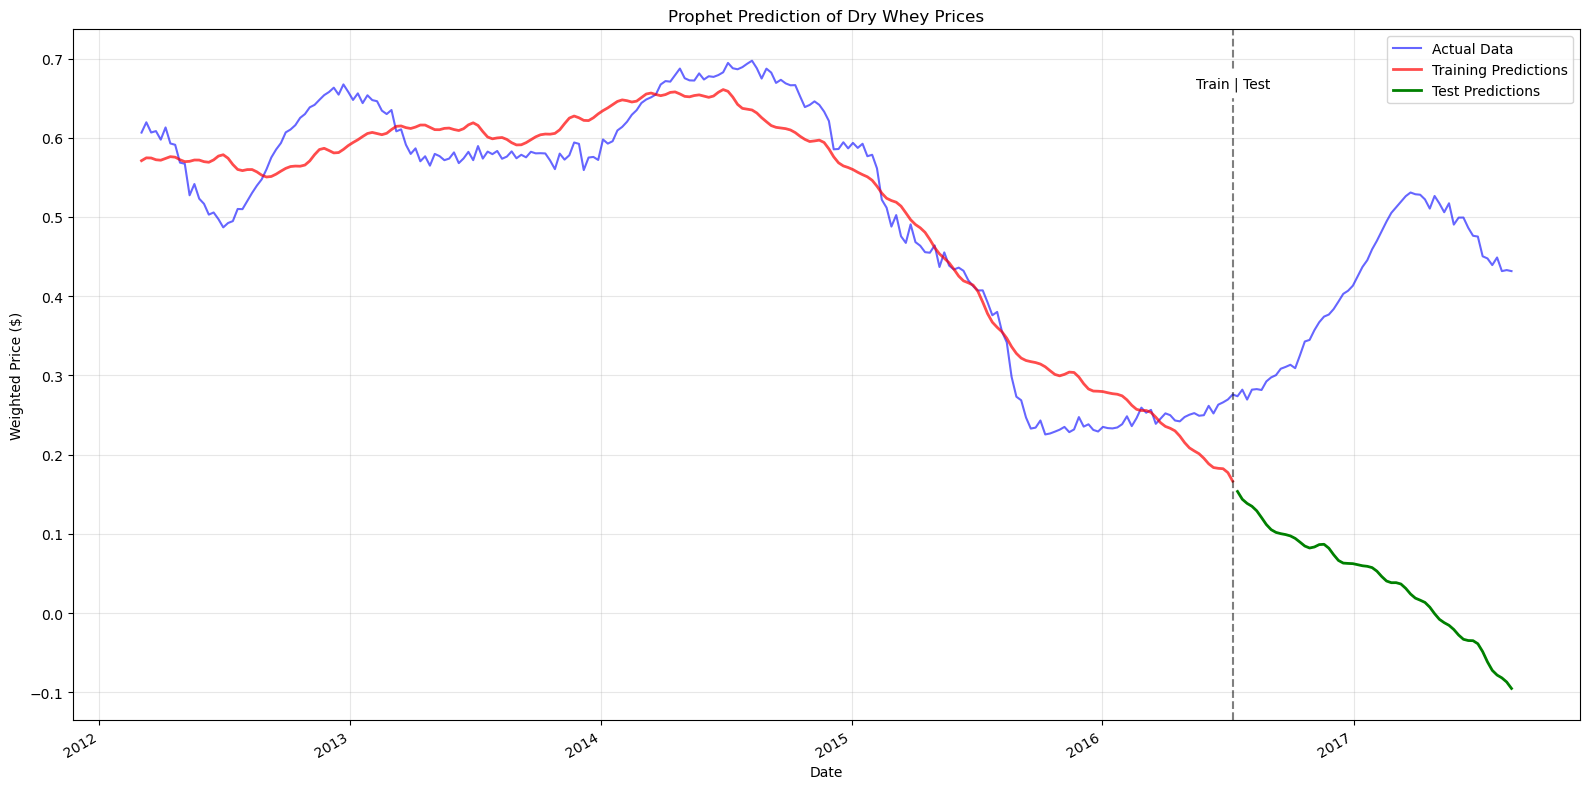

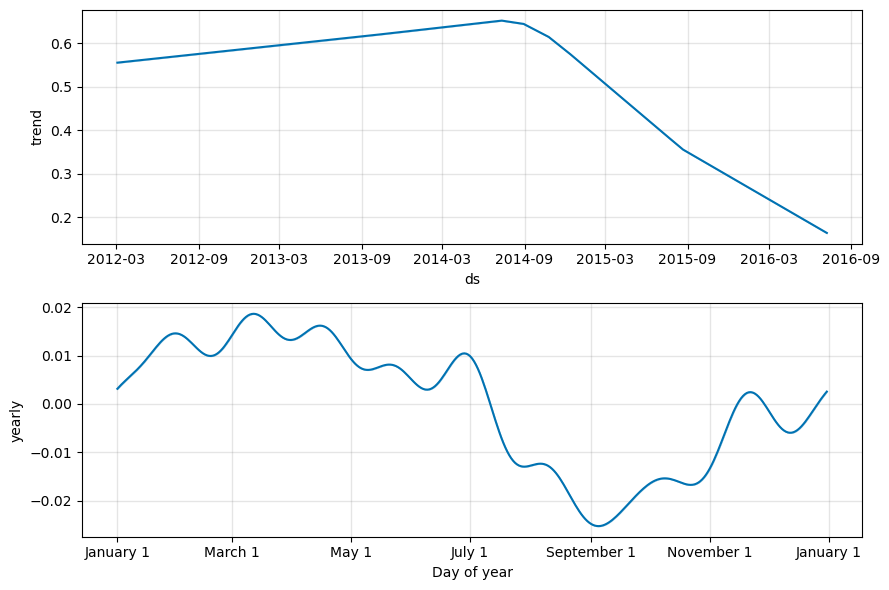

In [13]:
prophet_results = prophet_prediction(data)

In [14]:
def compare_models(lstm_results, prophet_results):
    """Compare the performance of LSTM and Prophet models."""
    models = ['LSTM', 'Prophet']
    metrics = ['RMSE', 'MAE', 'MAPE', 'R²']
    
    lstm_test = lstm_results['test_metrics']
    prophet_test = prophet_results['test_metrics']
    
    # Prepare data for bar chart
    rmse_values = [lstm_test['rmse'], prophet_test['rmse']]
    mae_values = [lstm_test['mae'], prophet_test['mae']]
    mape_values = [lstm_test['mape'], prophet_test['mape']]
    r2_values = [lstm_test['r2'], prophet_test['r2']]
    
    # Create subplots
    fig, axs = plt.subplots(2, 2, figsize=(14, 10))
    
    # RMSE
    axs[0, 0].bar(models, rmse_values, color=['blue', 'orange'])
    axs[0, 0].set_title('RMSE Comparison')
    axs[0, 0].set_ylabel('RMSE')
    for i, v in enumerate(rmse_values):
        axs[0, 0].text(i, v + 0.01, f'{v:.4f}', ha='center')
    
    # MAE
    axs[0, 1].bar(models, mae_values, color=['blue', 'orange'])
    axs[0, 1].set_title('MAE Comparison')
    axs[0, 1].set_ylabel('MAE')
    for i, v in enumerate(mae_values):
        axs[0, 1].text(i, v + 0.01, f'{v:.4f}', ha='center')
    
    # MAPE
    axs[1, 0].bar(models, mape_values, color=['blue', 'orange'])
    axs[1, 0].set_title('MAPE Comparison')
    axs[1, 0].set_ylabel('MAPE (%)')
    for i, v in enumerate(mape_values):
        axs[1, 0].text(i, v + 0.5, f'{v:.2f}%', ha='center')
    
    # R²
    axs[1, 1].bar(models, r2_values, color=['blue', 'orange'])
    axs[1, 1].set_title('R² Comparison')
    axs[1, 1].set_ylabel('R²')
    for i, v in enumerate(r2_values):
        axs[1, 1].text(i, v + 0.01, f'{v:.4f}', ha='center')
    
    plt.tight_layout()
    plt.show()
    
    # Print comparison summary
    print("\nModel Comparison Summary (Test Set):")
    print("=====================================")
    print(f"{'Metric':<10} {'LSTM':<15} {'Prophet':<15} {'Winner':<10}")
    print("-" * 50)
    
    for metric in ['rmse', 'mae', 'mape']:
        lstm_val = lstm_test[metric]
        prophet_val = prophet_test[metric]
        winner = "LSTM" if lstm_val < prophet_val else "Prophet"
        
        if metric == 'mape':
            print(f"{metric.upper():<10} {lstm_val:.2f}%{' ':<8} {prophet_val:.2f}%{' ':<8} {winner:<10}")
        else:
            print(f"{metric.upper():<10} {lstm_val:.4f}{' ':<8} {prophet_val:.4f}{' ':<8} {winner:<10}")
    
    # For R², higher is better
    lstm_r2 = lstm_test['r2']
    prophet_r2 = prophet_test['r2']
    r2_winner = "LSTM" if lstm_r2 > prophet_r2 else "Prophet"
    print(f"{'R²':<10} {lstm_r2:.4f}{' ':<8} {prophet_r2:.4f}{' ':<8} {r2_winner:<10}")

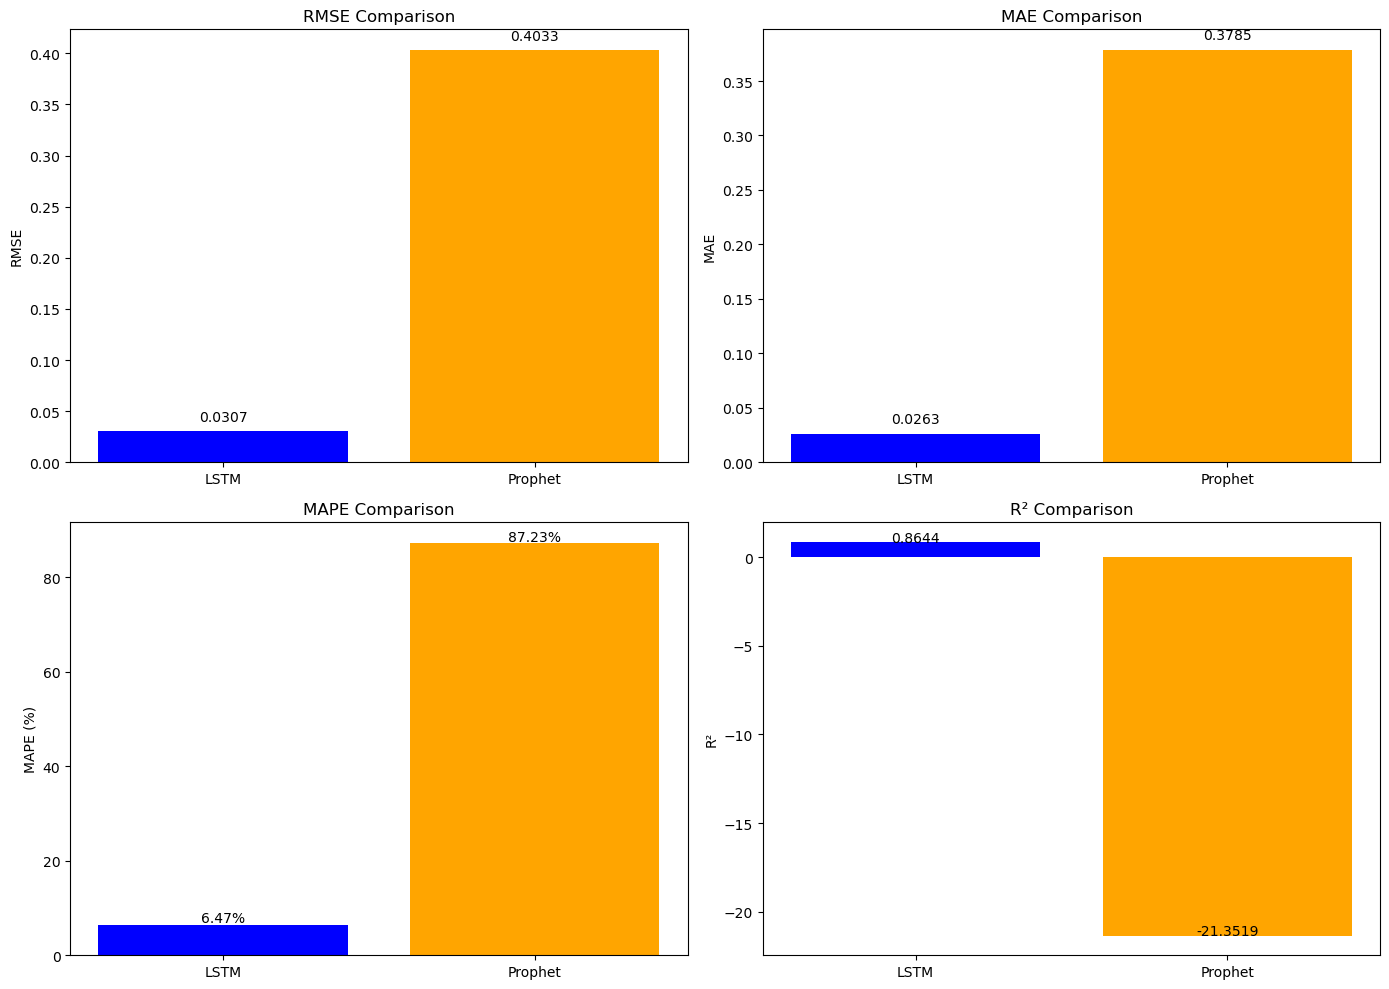


Model Comparison Summary (Test Set):
Metric     LSTM            Prophet         Winner    
--------------------------------------------------
RMSE       0.0307         0.4033         LSTM      
MAE        0.0263         0.3785         LSTM      
MAPE       6.47%         87.23%         LSTM      
R²         0.8644         -21.3519         LSTM      


In [15]:
compare_models(lstm_results, prophet_results)


# Resumo da Comparação de Modelos (Conjunto de Teste)

| Métrica | LSTM     | Prophet  | Vencedor |
|---------|----------|----------|----------|
| RMSE    | 0,0307   | 0,4033   | LSTM     |
| MAE     | 0,0263   | 0,3785   | LSTM     |
| MAPE    | 6,47%    | 87,23%   | LSTM     |
| R²      | 0,8644   | -21,3519 | LSTM     |

## Explicação das Métricas

1. **RMSE (Raiz do Erro Quadrático Médio)**:
   - Penaliza fortemente erros grandes devido à elevação ao quadrado
   - Adequado quando grandes erros são particularmente indesejáveis
   - Usado em previsões financeiras onde erros significativos podem ser custosos

2. **MAE (Erro Absoluto Médio)**:
   - Mede a magnitude média dos erros sem considerar a direção
   - Mais robusto a outliers do que RMSE
   - Facilmente interpretável nas mesmas unidades que os dados originais

3. **MAPE (Erro Percentual Absoluto Médio)**:
   - Expressa o erro como uma porcentagem, tornando-o independente de escala
   - Permite comparações entre diferentes conjuntos de dados
   - Pode ser problemático quando os valores reais estão próximos de zero

4. **R² (Coeficiente de Determinação)**:
   - Representa a proporção da variância explicada pelo modelo
   - Fornece uma indicação da qualidade do ajuste
   - Valores próximos a 1 indicam melhor ajuste; valores negativos indicam desempenho pior que a média simples

## Comparação dos Resultados

O modelo LSTM superou significativamente o Prophet em todas as métricas avaliadas:

- O **RMSE** do LSTM (0,0307) é aproximadamente 13 vezes menor que o do Prophet (0,4033), indicando que o LSTM produz erros muito menores, especialmente para os desvios maiores.

- O **MAE** do LSTM (0,0263) é cerca de 14 vezes menor que o do Prophet (0,3785), demonstrando que, em média, as previsões do LSTM estão significativamente mais próximas dos valores reais.

- O **MAPE** do LSTM (6,47%) comparado com o do Prophet (87,23%) mostra que o erro percentual do LSTM é drasticamente menor, o que é crucial para previsões de preços de commodities, onde a precisão porcentual tem implicações financeiras diretas.

- O **R²** do LSTM (0,8644) está próximo de 1, indicando que o modelo explica cerca de 86% da variabilidade dos dados. Em contraste, o R² negativo do Prophet (-21,3519) sugere que este modelo tem um desempenho extremamente ruim, sendo pior do que simplesmente prever a média dos valores observados.

Esta discrepância significativa no desempenho sugere que as séries temporais em questão possuem padrões complexos que o LSTM consegue capturar eficientemente com sua arquitetura de redes neurais recorrentes, enquanto o Prophet, que é baseado em decomposição de séries temporais, não consegue modelar adequadamente a dinâmica subjacente dos dados.
